In [1]:
import pandas as pd
import numpy as np
import re

from linearmodels import PanelOLS
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.get_option('display.max_rows', None)

60

In [4]:
exposure_df = pd.read_csv("./data/AI Exposure Scores/occ_level.csv")

In [5]:
exposure_df.columns

Index(['O*NET-SOC Code', 'Title', 'dv_rating_alpha', 'dv_rating_beta',
       'dv_rating_gamma', 'human_rating_alpha', 'human_rating_beta',
       'human_rating_gamma'],
      dtype='object')

In [6]:
df_2020 = pd.read_csv(r"./data/POSTINGS_LINKEDIN_SG/SG-2020.csv")
df_2021 = pd.read_csv(r"./data/POSTINGS_LINKEDIN_SG/SG-2021.csv")
df_2022 = pd.read_csv(r"./data/POSTINGS_LINKEDIN_SG/SG-2022.csv")
df_2023 = pd.read_csv(r"./data/POSTINGS_LINKEDIN_SG/SG-2023.csv")
df_2024 = pd.read_csv(r"./data/POSTINGS_LINKEDIN_SG/SG-2024.csv")

In [7]:
data_df = pd.concat([df_2021, df_2022, df_2023, df_2024])

In [8]:
data_df.columns

Index(['job_id', 'rcid', 'company', 'rics_k50', 'rics_k200', 'rics_k400',
       'title_raw', 'title_translated', 'role_k10', 'role_k25', 'role_k50',
       'role_k100', 'role_k150', 'role_k250', 'role_k500', 'role_k1000',
       'role_k1500', 'role_k2500', 'role_k5000', 'role_k10000', 'role_k15000',
       'mapped_role', 'location_raw', 'region', 'country', 'state',
       'metro_area', 'salary', 'post_date', 'remove_date',
       'ultimate_parent_rcid', 'ultimate_parent_company_name', 'onet_code',
       'onet_title', 'remote_type', 'jobtitle', 'description', 'salary_min',
       'salary_max', 'salary_predicted'],
      dtype='object')

In [9]:
data_df['rics_k50'].unique()

array(['Human Resources Services', 'Business Services',
       'Engineering and Construction Services',
       'Logistics and Transportation', 'Information Technology Services',
       'Electronics Manufacturing', 'Digital Commerce Services',
       'IT Consulting Services', 'Education Services',
       'Culture and Entertainment', 'Energy and Resources',
       'Media and Entertainment', 'Automotive Services',
       'Consumer Technology Distribution',
       'Hospitality and Tourism Management', 'Retail and Consumer Goods',
       'Facility Management Services', 'Apparel Retail',
       'Food and Beverage', 'Financial Services',
       'Public Sector Management', 'Consulting and Advisory Services',
       'Healthcare and Wellness Services',
       'Marketing and Advertising Services',
       'Real Estate and Development', 'Professional Development Services',
       'Biotech and Healthcare Services', 'Automation Solutions',
       'Legal Services', 'Miscellaneous', 'Aerospace and Defe

# 15.12.25

No median split, aggregating data into panel with continuous GenAI exposure score

In [10]:
import pandas as pd
import numpy as np

# -----------------------------
# CONFIG
# -----------------------------
# Choose your industry level here (pick ONE that matches your regression)
IND_COL = "rics_k50"     # or "rics_k200", "rics_k400"
DATE_COL = "post_date"   # uses posting date to place ads into quarters
ONET_COL = "onet_code"

# -----------------------------
# 1) Prep microdata
# -----------------------------
df = data_df.copy()

# Ensure datetime
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[ONET_COL, IND_COL, DATE_COL])

# Quarter label: "2022Q4"
q = df[DATE_COL].dt.to_period("Q")
df["quarter"] = q.astype(str)  # e.g., "2022Q4"

# Keep only needed columns for aggregation
df_small = df[[ONET_COL, IND_COL, "quarter", "job_id"]].copy()

# -----------------------------
# 2) Aggregate to occ×industry×quarter postings count
# -----------------------------
panel = (
    df_small
    .groupby([ONET_COL, IND_COL, "quarter"], as_index=False)
    .agg(n_postings=("job_id", "count"))
)

# -----------------------------
# 3) Balance the panel within each occ×industry pair
#    (keep pairs that ever appeared; fill missing quarters with 0 postings)
# -----------------------------
all_quarters = pd.period_range(
    start=pd.Period(panel["quarter"].min(), freq="Q"),
    end=pd.Period(panel["quarter"].max(), freq="Q"),
    freq="Q"
).astype(str)

pairs = panel[[ONET_COL, IND_COL]].drop_duplicates()
pairs["_tmp"] = 1
qdf = pd.DataFrame({"quarter": all_quarters})
qdf["_tmp"] = 1

balanced_index = pairs.merge(qdf, on="_tmp", how="outer").drop(columns="_tmp")

panel_bal = (
    balanced_index
    .merge(panel, on=[ONET_COL, IND_COL, "quarter"], how="left")
    .fillna({"n_postings": 0})
)

panel_bal["n_postings"] = panel_bal["n_postings"].astype(int)

# Optionally: outcome used in your regressions
panel_bal["log_postings"] = np.log1p(panel_bal["n_postings"])

# -----------------------------
# 4) Merge continuous exposure scores from exposure_df
# -----------------------------
exp = exposure_df.copy()

# Normalize column name if needed
# exposure_df has "O*NET-SOC Code" — map it to ONET_COL
if "O*NET-SOC Code" in exp.columns and ONET_COL not in exp.columns:
    exp = exp.rename(columns={"O*NET-SOC Code": ONET_COL})

# Keep exposure columns only
keep_exp_cols = [ONET_COL] + [c for c in exp.columns if c != ONET_COL]
exp = exp[keep_exp_cols].drop_duplicates(subset=[ONET_COL])

panel_bal = panel_bal.merge(exp, on=ONET_COL, how="inner")  # drop if no exposure score

# -----------------------------
# 5) Create IDs for Stata + save .dta
# -----------------------------
panel_bal["occ_ind"] = panel_bal[ONET_COL].astype(str) + "||" + panel_bal[IND_COL].astype(str)

# Numeric panel id (good for xtset)
panel_bal["occ_ind_id"] = panel_bal["occ_ind"].astype("category").cat.codes + 1

# Create a Stata-friendly quarterly time index
# Stata quarterly date can be created later via: gen tq = yq(year, quarter)
# but we’ll also provide year and qtr_num
panel_bal["year"] = panel_bal["quarter"].str.slice(0,4).astype(int)
panel_bal["qtr_num"] = panel_bal["quarter"].str.extract(r"Q([1-4])").astype(int)

out_path = "occ_ind_quarter_panel.dta"

# Stata string length constraints: keep strings reasonable
for col in [ONET_COL, IND_COL, "quarter", "occ_ind"]:
    panel_bal[col] = panel_bal[col].astype(str)

panel_bal.to_stata(out_path, write_index=False)
print("Saved:", out_path)


Saved: occ_ind_quarter_panel.dta


In [11]:
panel_bal

,onet_code,rics_k50,quarter,n_postings,log_postings,Title,dv_rating_alpha,dv_rating_beta,dv_rating_gamma,human_rating_alpha,human_rating_beta,human_rating_gamma,occ_ind,occ_ind_id,year,qtr_num
0,11-1011.00,Aerospace and Defense,2021Q1,1,0.693147,Chief Executives,0.100000,0.460000,0.820000,0.180000,0.350000,0.520000,11-1011.00||Aerospace and Defense,1,2021,1
1,11-1011.00,Aerospace and Defense,2021Q2,3,1.386294,Chief Executives,0.100000,0.460000,0.820000,0.180000,0.350000,0.520000,11-1011.00||Aerospace and Defense,1,2021,2
2,11-1011.00,Aerospace and Defense,2021Q3,3,1.386294,Chief Executives,0.100000,0.460000,0.820000,0.180000,0.350000,0.520000,11-1011.00||Aerospace and Defense,1,2021,3
3,11-1011.00,Aerospace and Defense,2021Q4,2,1.098612,Chief Executives,0.100000,0.460000,0.820000,0.180000,0.350000,0.520000,11-1011.00||Aerospace and Defense,1,2021,4
4,11-1011.00,Aerospace and Defense,2022Q1,5,1.791759,Chief Executives,0.100000,0.460000,0.820000,0.180000,0.350000,0.520000,11-1011.00||Aerospace and Defense,1,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229867,53-7065.00,Wellness Products,2023Q4,9,2.302585,Stockers and Order Fillers,0.109091,0.181818,0.254545,0.109091,0.190909,0.272727,53-7065.00||Wellness Products,14367,2023,4
229868,53-7065.00,Wellness Products,2024Q1,10,2.397895,Stockers and Order Fillers,0.109091,0.181818,0.254545,0.109091,0.190909,0.272727,53-7065.00||Wellness Products,14367,2024,1
229869,53-7065.00,Wellness Products,2024Q2,7,2.079442,Stockers and Order Fillers,0.109091,0.181818,0.254545,0.109091,0.190909,0.272727,53-7065.00||Wellness Products,14367,2024,2
229870,53-7065.00,Wellness Products,2024Q3,23,3.178054,Stockers and Order Fillers,0.109091,0.181818,0.254545,0.109091,0.190909,0.272727,53-7065.00||Wellness Products,14367,2024,3


# 10.01.11

In [64]:
import pandas as pd
import numpy as np

# -----------------------------
# Helpers
# -----------------------------
def onet_normalize_full(x):
    if pd.isna(x):
        return pd.NA
    return str(x).strip()

def onet_stem(x):
    if pd.isna(x):
        return pd.NA
    return str(x).strip().split('.')[0]  # "15-1121.00" -> "15-1121"

# -----------------------------
# 1) Prep exposure (occ-level)
# -----------------------------
exp = exposure_df.copy()
exp['ai_exposure'] = exp[['dv_rating_beta','human_rating_beta']].mean(axis=1).fillna(0.0)
exp['onet_full']   = exp['O*NET-SOC Code'].map(onet_normalize_full)
exp['occ']         = exp['O*NET-SOC Code'].map(onet_stem)

occ_exposure = (
    exp.groupby('occ', as_index=False)['ai_exposure']
       .mean()
       .rename(columns={'ai_exposure': 'occ_ai_exposure'})
)

# -----------------------------
# 2) Clean postings & restrict time (2022Q1+), REMOVE empty onet codes
# -----------------------------
df = data_df.copy()

# Normalize to pandas StringDtype and strip
df['onet_code'] = df['onet_code'].astype('string').str.strip()

# Convert common "empty" tokens to missing, then drop
empty_tokens = ['','nan','none','null','.','na','N/A','NaN','None','NULL']
df['onet_code'] = df['onet_code'].replace(empty_tokens, pd.NA)
df = df.dropna(subset=['onet_code'])

# Map to stem occ; drop rows where stem failed (paranoia)
df['occ'] = df['onet_code'].map(onet_stem).astype('string')
df = df.dropna(subset=['occ'])

# Time
df['post_date'] = pd.to_datetime(df['post_date'], errors='coerce')
df = df.dropna(subset=['post_date'])

# Keep quarters >= 2022Q1
df['year_quarter'] = df['post_date'].dt.to_period('Q').astype(str)
first_q = pd.Period('2022Q1', freq='Q')
df = df[pd.PeriodIndex(df['year_quarter'], freq='Q') >= first_q]

# Industry key
df['ind'] = df['rics_k50'].astype('string')

# -----------------------------
# 3) Pre-treatment median (occupations observed pre-2023Q1)
# -----------------------------
pre_mask = pd.PeriodIndex(df['year_quarter'], freq='Q') < pd.Period('2023Q1', freq='Q')
pre_occs = df.loc[pre_mask, 'occ'].dropna().unique()

pre_pool = occ_exposure.loc[occ_exposure['occ'].isin(pre_occs), 'occ_ai_exposure']
if pre_pool.empty:
    # Fallback: median over occs that appear anywhere in 2022Q1+ data
    any_occs = df['occ'].dropna().unique()
    pre_pool = occ_exposure.loc[occ_exposure['occ'].isin(any_occs), 'occ_ai_exposure']

pre_median = float(pre_pool.median()) if not pre_pool.empty else float(occ_exposure['occ_ai_exposure'].median())
print(f"[INFO] Pre-treatment median occ-level exposure used for treated split = {pre_median:.4f}")

# -----------------------------
# 4) Panel grid = (observed occ×ind pairs) × (all quarters)
# -----------------------------
obs_pairs = (
    df[['occ','ind']]
    .dropna()
    .drop_duplicates()
    .reset_index(drop=True)
)

# Quarter range: 2022Q1 .. last quarter in data
max_q = pd.Period(df['year_quarter'].max(), freq='Q') if len(df) else first_q
all_quarters = pd.period_range(first_q, max_q, freq='Q').astype(str)
q_df = pd.DataFrame({'year_quarter': all_quarters})

# Cartesian product of observed pairs with all quarters
obs_pairs['_k'] = 1
q_df['_k'] = 1
panel = obs_pairs.merge(q_df, on='_k').drop(columns=['_k'])

# -----------------------------
# 5) Aggregate postings & merge exposure
# -----------------------------
cell_counts = (
    df.groupby(['occ','ind','year_quarter'], as_index=False)
      .agg(num_postings=('job_id','count'))
)

panel = panel.merge(cell_counts, on=['occ','ind','year_quarter'], how='left')
panel['num_postings'] = panel['num_postings'].fillna(0).astype('int64')
panel['log_postings'] = np.log(panel['num_postings'] + 1)

# Merge occ-level exposure
panel = panel.merge(occ_exposure, on='occ', how='left')
panel['occ_ai_exposure'] = panel['occ_ai_exposure'].fillna(0.0)

# -----------------------------
# 6) Treatment (above pre-period median) and Post (>= 2023Q1)
# -----------------------------
panel['treated'] = (panel['occ_ai_exposure'] > pre_median).astype('int8')

panel_periods = pd.PeriodIndex(panel['year_quarter'], freq='Q')
panel['post'] = (panel_periods >= pd.Period('2023Q1', freq='Q')).astype('int8')

# -----------------------------
# 7) Stata-friendly export
# -----------------------------
panel_df = (
    panel[['occ','ind','year_quarter',
           'num_postings','log_postings',
           'occ_ai_exposure','treated','post']]
    .sort_values(['occ','ind','year_quarter'])
    .reset_index(drop=True)
)

# panel_df.to_csv("panel_df_obs_pairs_median_pre_treat.csv", index=False)
print(panel_df.head(), panel_df.shape)

[INFO] Pre-treatment median occ-level exposure used for treated split = 0.4261
       occ                    ind year_quarter  num_postings  log_postings  \
0  11-1011  Aerospace and Defense       2022Q1             9      2.302585   
1  11-1011  Aerospace and Defense       2022Q2            10      2.397895   
2  11-1011  Aerospace and Defense       2022Q3             6      1.945910   
3  11-1011  Aerospace and Defense       2022Q4             8      2.197225   
4  11-1011  Aerospace and Defense       2023Q1             5      1.791759   

   occ_ai_exposure  treated  post  
0         0.438611        1     0  
1         0.438611        1     0  
2         0.438611        1     0  
3         0.438611        1     0  
4         0.438611        1     1   (145692, 8)


In [67]:
panel_df = panel_df[panel_df['occ'] != "empty"]
panel_df.to_stata("panel_pre_treatment_median_101125.dta")

In [74]:
exposure_df[exposure_df['O*NET-SOC Code'].isin(panel_df[panel_df['ind']=="Aerospace and Defense"]['occ'].unique())]

,O*NET-SOC Code,Title,dv_rating_alpha,dv_rating_beta,dv_rating_gamma,human_rating_alpha,human_rating_beta,human_rating_gamma
0,11-1011,Chief Executives,0.100000,0.460000,0.820000,0.180000,0.350000,0.520000
1,11-1011,Chief Sustainability Officers,0.166667,0.555556,0.944444,0.055556,0.388889,0.722222
2,11-1021,General and Operations Managers,0.000000,0.480769,0.961538,0.115385,0.384615,0.653846
3,11-1031,Legislators,0.033333,0.400000,0.766667,0.266667,0.516667,0.766667
4,11-2011,Advertising and Promotions Managers,0.000000,0.476744,0.953488,0.255814,0.546512,0.837209
...,...,...,...,...,...,...,...,...
903,53-6051,Transportation Inspectors,0.272727,0.439394,0.606061,0.060606,0.318182,0.575758
904,53-6051,Aviation Inspectors,0.080000,0.340000,0.600000,0.120000,0.260000,0.400000
905,53-6051,"Transportation Vehicle, Equipment and Systems ...",0.208333,0.458333,0.708333,0.000000,0.125000,0.250000
916,53-7064,"Packers and Packagers, Hand",0.100000,0.100000,0.100000,0.000000,0.100000,0.200000


# 09.01.11

In [45]:
import pandas as pd
import numpy as np

# -----------------------------
# Helpers
# -----------------------------
def onet_normalize_full(x):
    if pd.isna(x):
        return np.nan
    return str(x).strip()

def onet_stem(x):
    if pd.isna(x):
        return np.nan
    return str(x).strip().split('.')[0]  # "15-1121.00" -> "15-1121"

# -----------------------------
# 1) Prep exposure (unchanged)
# -----------------------------
exp = exposure_df.copy()
exp['ai_exposure'] = exp[['dv_rating_beta','human_rating_beta']].mean(axis=1).fillna(0.0)
exp['onet_full']   = exp['O*NET-SOC Code'].map(onet_normalize_full)
exp['occ']         = exp['O*NET-SOC Code'].map(onet_stem)

occ_exposure = (
    exp.groupby('occ', as_index=False)['ai_exposure']
       .mean()
       .rename(columns={'ai_exposure': 'occ_ai_exposure'})
)
occ_exposure['treated'] = (occ_exposure['occ_ai_exposure'] > 0).astype(int)

# -----------------------------
# 2) Clean postings & restrict time (unchanged)
# -----------------------------
df = data_df.copy()

# Drop empty/NA onet_code rows
df['onet_code'] = df['onet_code'].astype(str).str.strip()
df = df[df['onet_code'].ne('') & df['onet_code'].notna()]

# Normalize to stem occ
df['occ'] = df['onet_code'].map(onet_stem)

# Time
df['post_date'] = pd.to_datetime(df['post_date'], errors='coerce')
df = df.dropna(subset=['post_date'])

# Keep quarters >= 2022Q1
df['year_quarter'] = df['post_date'].dt.to_period('Q').astype(str)
first_q = pd.Period('2022Q1', freq='Q')
df = df[pd.PeriodIndex(df['year_quarter'], freq='Q') >= first_q]

# Industry key
df['ind'] = df['rics_k50']

# -----------------------------
# 3) Panel grid = (observed occ×ind pairs) × (all quarters)
# -----------------------------
# observed pairs that ever appear at least once (after the 2022Q1+ filter)
obs_pairs = (
    df[['occ','ind']]
    .dropna()
    .drop_duplicates()
    .reset_index(drop=True)
)

# Quarter range: 2022Q1 .. last quarter in data (graceful if df is empty)
if len(df):
    max_q = pd.Period(df['year_quarter'].max(), freq='Q')
else:
    max_q = first_q

all_quarters = pd.period_range(first_q, max_q, freq='Q').astype(str)
q_df = pd.DataFrame({'year_quarter': all_quarters})

# Cartesian product of observed pairs with all quarters
obs_pairs['_k'] = 1
q_df['_k'] = 1
panel = obs_pairs.merge(q_df, on='_k').drop(columns=['_k'])

# -----------------------------
# 4) Aggregate postings & merge exposure/treatment (unchanged)
# -----------------------------
cell_counts = (
    df.groupby(['occ','ind','year_quarter'], as_index=False)
      .agg(num_postings=('job_id','count'))
)

panel = panel.merge(cell_counts, on=['occ','ind','year_quarter'], how='left')
panel['num_postings'] = panel['num_postings'].fillna(0).astype(int)
panel['log_postings'] = np.log(panel['num_postings'] + 1)

# Merge occ-level exposure & treated
panel = panel.merge(occ_exposure, on='occ', how='left')
panel['occ_ai_exposure'] = panel['occ_ai_exposure'].fillna(0.0)
panel['treated'] = panel['treated'].fillna(0).astype(int)

# -----------------------------
# 5) Post indicator (>= 2023Q1)
# -----------------------------
panel_periods = pd.PeriodIndex(panel['year_quarter'], freq='Q')
panel['post'] = (panel_periods >= pd.Period('2023Q1', freq='Q')).astype(int)

# -----------------------------
# 6) Stata-friendly export
# -----------------------------
panel_df = (
    panel[['occ','ind','year_quarter',
           'num_postings','log_postings',
           'occ_ai_exposure','treated','post']]
    .sort_values(['occ','ind','year_quarter'])
    .reset_index(drop=True)
)

# panel_df.to_csv("panel_df_obs_pairs_2022q1_plus.csv", index=False)
print(panel_df.head(), panel_df.shape)

       occ                    ind year_quarter  num_postings  log_postings  \
0  11-1011  Aerospace and Defense       2022Q1             9      2.302585   
1  11-1011  Aerospace and Defense       2022Q2            10      2.397895   
2  11-1011  Aerospace and Defense       2022Q3             6      1.945910   
3  11-1011  Aerospace and Defense       2022Q4             8      2.197225   
4  11-1011  Aerospace and Defense       2023Q1             5      1.791759   

   occ_ai_exposure  treated  post  
0         0.438611        1     0  
1         0.438611        1     0  
2         0.438611        1     0  
3         0.438611        1     0  
4         0.438611        1     1   (145692, 8)


In [47]:
panel_df.to_stata("panel_clean_treatment_091125.dta")

In [48]:
valid_occs = panel_df[panel_df['treated'] == 0]['occ'].unique()
valid_occs = valid_occs[valid_occs != 'empty']

In [49]:
valid_occs

array(['27-2021', '35-2015', '35-9021', '47-2071', '47-3012', '49-3093'],
      dtype=object)

In [50]:
no_exposure_df = panel_df[panel_df['occ_ai_exposure'] == 0]

In [52]:
no_exposure_df.to_csv('no_exposure.csv')

In [53]:
merged_df = no_exposure_df.merge(
    exposure_df,
    left_on='occ',
    right_on='O*NET-SOC Code',
    how='left'
)

merged_df.to_csv('no_exposure_with_title.csv')

In [27]:
exposure_df.head()

,O*NET-SOC Code,Title,dv_rating_alpha,dv_rating_beta,dv_rating_gamma,human_rating_alpha,human_rating_beta,human_rating_gamma
0,11-1011.00,Chief Executives,0.100000,0.460000,0.820000,0.180000,0.350000,0.520000
1,11-1011.03,Chief Sustainability Officers,0.166667,0.555556,0.944444,0.055556,0.388889,0.722222
2,11-1021.00,General and Operations Managers,0.000000,0.480769,0.961538,0.115385,0.384615,0.653846
3,11-1031.00,Legislators,0.033333,0.400000,0.766667,0.266667,0.516667,0.766667
4,11-2011.00,Advertising and Promotions Managers,0.000000,0.476744,0.953488,0.255814,0.546512,0.837209


In [30]:
exposure_df['O*NET-SOC Code'] = exposure_df['O*NET-SOC Code'].astype(str).str.split('.').str[0]

In [38]:
exposure_df[exposure_df['O*NET-SOC Code'].isin(valid_occs)]

,O*NET-SOC Code,Title,dv_rating_alpha,dv_rating_beta,dv_rating_gamma,human_rating_alpha,human_rating_beta,human_rating_gamma
355,27-2021,Athletes and Sports Competitors,0.0,0.0,0.0,0.0,0.0,0.0
519,35-2015,"Cooks, Short Order",0.0,0.0,0.0,0.0,0.0,0.0
526,35-9011,Dining Room and Cafeteria Attendants and Barte...,0.0,0.0,0.0,0.0,0.0,0.0
527,35-9021,Dishwashers,0.0,0.0,0.0,0.0,0.0,0.0
645,45-2091,Agricultural Equipment Operators,0.0,0.0,0.0,0.0,0.0,0.0
657,47-2022,Stonemasons,0.0,0.0,0.0,0.0,0.0,0.0
660,47-2042,"Floor Layers, Except Carpet, Wood, and Hard Tiles",0.0,0.0,0.0,0.0,0.0,0.0
663,47-2051,Cement Masons and Concrete Finishers,0.0,0.0,0.0,0.0,0.0,0.0
666,47-2071,"Paving, Surfacing, and Tamping Equipment Opera...",0.0,0.0,0.0,0.0,0.0,0.0
667,47-2072,Pile Driver Operators,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
panel_df.to_stata("panel_clean_treatment_091125.dta")

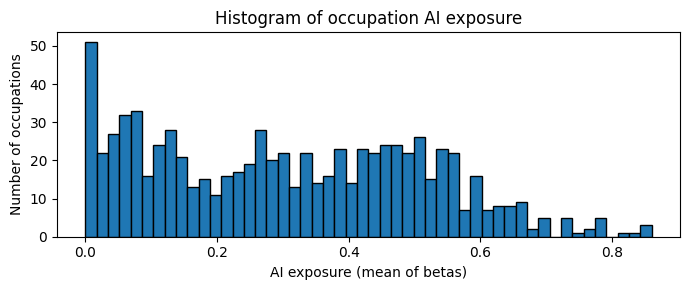

In [54]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# 1) Occ-level exposure (mean of betas)
exp = exposure_df.copy()
exp['ai_exposure'] = exp[['dv_rating_beta','human_rating_beta']].mean(axis=1)
exp['occ'] = exp['O*NET-SOC Code'].astype(str).str.strip().str.split('.').str[0]

occ_exp = (
    exp.groupby('occ', as_index=False)['ai_exposure']
       .mean()
)

# 2a) Fine histogram to see the overall shape
plt.figure(figsize=(7,3))
plt.hist(occ_exp['ai_exposure'], bins=50, edgecolor='k')
plt.xlabel("AI exposure (mean of betas)")
plt.ylabel("Number of occupations")
plt.title("Histogram of occupation AI exposure")
plt.tight_layout()
plt.show()

In [56]:
exp['ai_exposure'].median()

0.328125

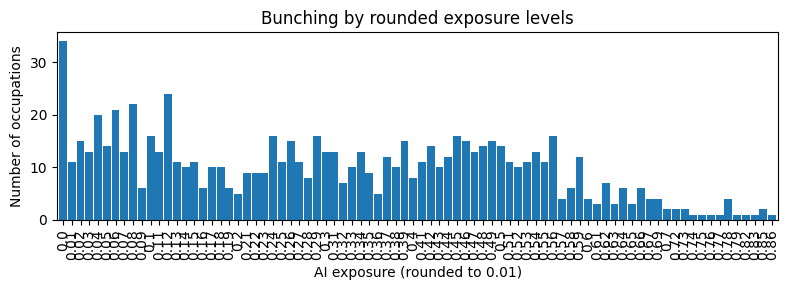

ai_exposure
(-1e-09, 0.0]     34
(0.0, 0.01]        3
(0.01, 0.02]      18
(0.02, 0.05]      45
(0.05, 0.1]       79
(0.1, 1.0]       619
Name: count, dtype: int64


In [55]:
# 2b) Bunching at exact values (bar chart of rounded levels)
counts = (
    occ_exp['ai_exposure'].round(2)           # round to hundredths; change to .01/.05 as you like
           .value_counts()
           .sort_index()
)
plt.figure(figsize=(8,3))
counts.plot(kind='bar', width=0.9)
plt.xlabel("AI exposure (rounded to 0.01)")
plt.ylabel("Number of occupations")
plt.title("Bunching by rounded exposure levels")
plt.tight_layout()
plt.show()

# 2c) Quick counts for near-zero bands (sanity checks)
cut_counts = pd.cut(occ_exp['ai_exposure'], bins=[-1e-9, 0, 0.01, 0.02, 0.05, 0.1, 1.0]).value_counts().sort_index()
print(cut_counts)